In [1]:
from collections import defaultdict
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from tqdm.auto import tqdm
import pandas as pd
from SoccerNet.Evaluation.utils_calibration import SoccerPitch


from tvcalib.cam_modules import SNProjectiveCamera
from tvcalib.module import TVCalibModule
from tvcalib.cam_distr.tv_main_center import get_cam_distr, get_dist_distr
from sn_segmentation.src.custom_extremities import generate_class_synthesis, get_line_extremities
from tvcalib.sncalib_dataset import custom_list_collate, split_circle_central
from tvcalib.utils.io import detach_dict, tensor2list
from tvcalib.utils.objects_3d import SoccerPitchLineCircleSegments, SoccerPitchSNCircleCentralSplit
from tvcalib.inference import InferenceDatasetCalibration, InferenceDatasetSegmentation, InferenceSegmentationModel
from tvcalib.inference import get_camera_from_per_sample_output
from tvcalib.utils import visualization_mpl_min as viz


args = Namespace(
        images_path=Path("data/datasets/wc14-test"),
        output_dir=Path("tmp"),
        checkpoint="data/segment_localization/train_59.pt",
        gpu=True,
        nworkers=16,
        batch_size_seg=16,
        batch_size_calib=256,
        image_width=2858,
        image_height=1588,
        optim_steps=2000,
        lens_dist=True,
        write_masks=False
    )
device = "cuda" if args.gpu and torch.cuda.is_available() else "cpu"

object3d = SoccerPitchLineCircleSegments(
    device=device, base_field=SoccerPitchSNCircleCentralSplit()
)
object3dcpu = SoccerPitchLineCircleSegments(
    device="cpu", base_field=SoccerPitchSNCircleCentralSplit()
)

lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

fn_generate_class_synthesis = partial(generate_class_synthesis, radius=4)
fn_get_line_extremities = partial(get_line_extremities, maxdist=30, width=455, height=256, num_points_lines=4, num_points_circles=8)

Global seed set to 10


In [2]:
dataset_seg = InferenceDatasetSegmentation(
    args.images_path, args.image_width, args.image_height
)
print("number of images:", len(dataset_seg))
dataloader_seg = torch.utils.data.DataLoader(
    dataset_seg,
    batch_size=args.batch_size_seg,
    num_workers=12,
    shuffle=False,
    collate_fn=custom_list_collate,
)

model_seg = InferenceSegmentationModel(args.checkpoint, device)

image_ids = []
keypoints_raw = []
(args.output_dir / "masks").mkdir(parents=True, exist_ok=True)
for batch_dict in tqdm(dataloader_seg):
    # semantic segmentation
    # image_raw: [B, 3, image_height, image_width]
    # image: [B, 3, 256, 455]
    with torch.no_grad():
        sem_lines = model_seg.inference(batch_dict["image"].to(device))
    sem_lines = sem_lines.cpu().numpy().astype(np.uint8)  # [B, 256, 455]

    # point selection
    with Pool(args.nworkers) as p:
        skeletons_batch = p.map(fn_generate_class_synthesis, sem_lines)
        keypoints_raw_batch = p.map(fn_get_line_extremities, skeletons_batch)

    # write to file
    if args.write_masks:
        print("Write masks to file")
        for image_id, mask in zip(batch_dict["image_id"], sem_lines):
            mask = Image.fromarray(mask.astype(np.uint8)).convert("P")
            mask.putpalette(lines_palette)
            mask.convert("RGB").save(args.output_dir / "masks" / image_id)

    image_ids.extend(batch_dict["image_id"])
    keypoints_raw.extend(keypoints_raw_batch)


number of images: 1


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
model_calib = TVCalibModule(
    object3d,
    get_cam_distr(1.96, args.batch_size_calib, 1),
    get_dist_distr(args.batch_size_calib, 1) if args.lens_dist else None,
    (args.image_height, args.image_width),
    args.optim_steps,
    device,
    log_per_step=False,
    tqdm_kwqargs=None,
)

dataset_calib = InferenceDatasetCalibration(keypoints_raw, args.image_width, args.image_height, object3d)
dataloader_calib = torch.utils.data.DataLoader(dataset_calib, args.batch_size_calib, collate_fn=custom_list_collate)

per_sample_output = defaultdict(list)
per_sample_output["image_id"] = [[x] for x in image_ids]
for x_dict in dataloader_calib:
    _batch_size = x_dict["lines__ndc_projected_selection_shuffled"].shape[0]

    points_line = x_dict["lines__px_projected_selection_shuffled"]
    points_circle = x_dict["circles__px_projected_selection_shuffled"]
    print(f"{points_line.shape=}, {points_circle.shape=}")

    per_sample_loss, cam, _ = model_calib.self_optim_batch(x_dict)
    output_dict = tensor2list(detach_dict({**cam.get_parameters(_batch_size), **per_sample_loss}))
    
    output_dict["points_line"] = points_line
    output_dict["points_circle"] =  points_circle
    for k in output_dict.keys():
        per_sample_output[k].extend(output_dict[k])

df = pd.DataFrame.from_dict(per_sample_output)

df = df.explode(column=[k for k, v in per_sample_output.items() if isinstance(v, list)])
df.set_index("image_id", inplace=True, drop=False)
df

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the a

points_line.shape=torch.Size([1, 1, 3, 23, 4]), points_circle.shape=torch.Size([1, 1, 3, 4, 8])


  0%|          | 0/2000 [00:00<?, ?it/s]

,image_id,pan_degrees,tilt_degrees,roll_degrees,position_meters,aov_radian,aov_degrees,x_focal_length,y_focal_length,principal_point,...,thin_prism_distortion,mask_lines,mask_circles,loss_ndc_lines_distances_raw,loss_ndc_lines,loss_ndc_circles_distances_raw,loss_ndc_circles,loss_ndc_total,points_line,points_circle
image_id,,,,,,,,,,,,,,,,,,,,,
pitch_lines_center.png,pitch_lines_center.png,-1.499548,86.768318,-10.0,"[0.9883021116256714, 110.0, -5.0]",0.445112,25.503035,6314.494141,6314.494141,"[1429.0, 794.0]",...,"[0.0, 0.0, 0.0, 0.0]","[[[False, False, False, False], [False, False,...","[[[True, True, True, False, False, False, Fals...","[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",0.077952,"[[[0.12587769329547882, 6.103515625e-05, 0.278...",0.136322,0.214274,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(1017.2176), tensor(1400.2439), tenso..."


In [7]:
print(df.mask_circles.to_numpy())

[list([[[True, True, True, False, False, False, False, False], [True, True, True, False, False, True, True, False], [False, False, False, False, False, False, False, False], [False, False, False, False, False, False, False, False]]])]


image_id='pitch_lines_center'
aov_deg=tensor([[25.5030]]), t=tensor([[[  0.9883, 110.0000,  -5.0000]]]), pan_deg=tensor([[-1.4995]]) tilt_deg=tensor([[86.7683]]) roll_deg=tensor([[-10.]]) lens dist coeff=0.50 0.10


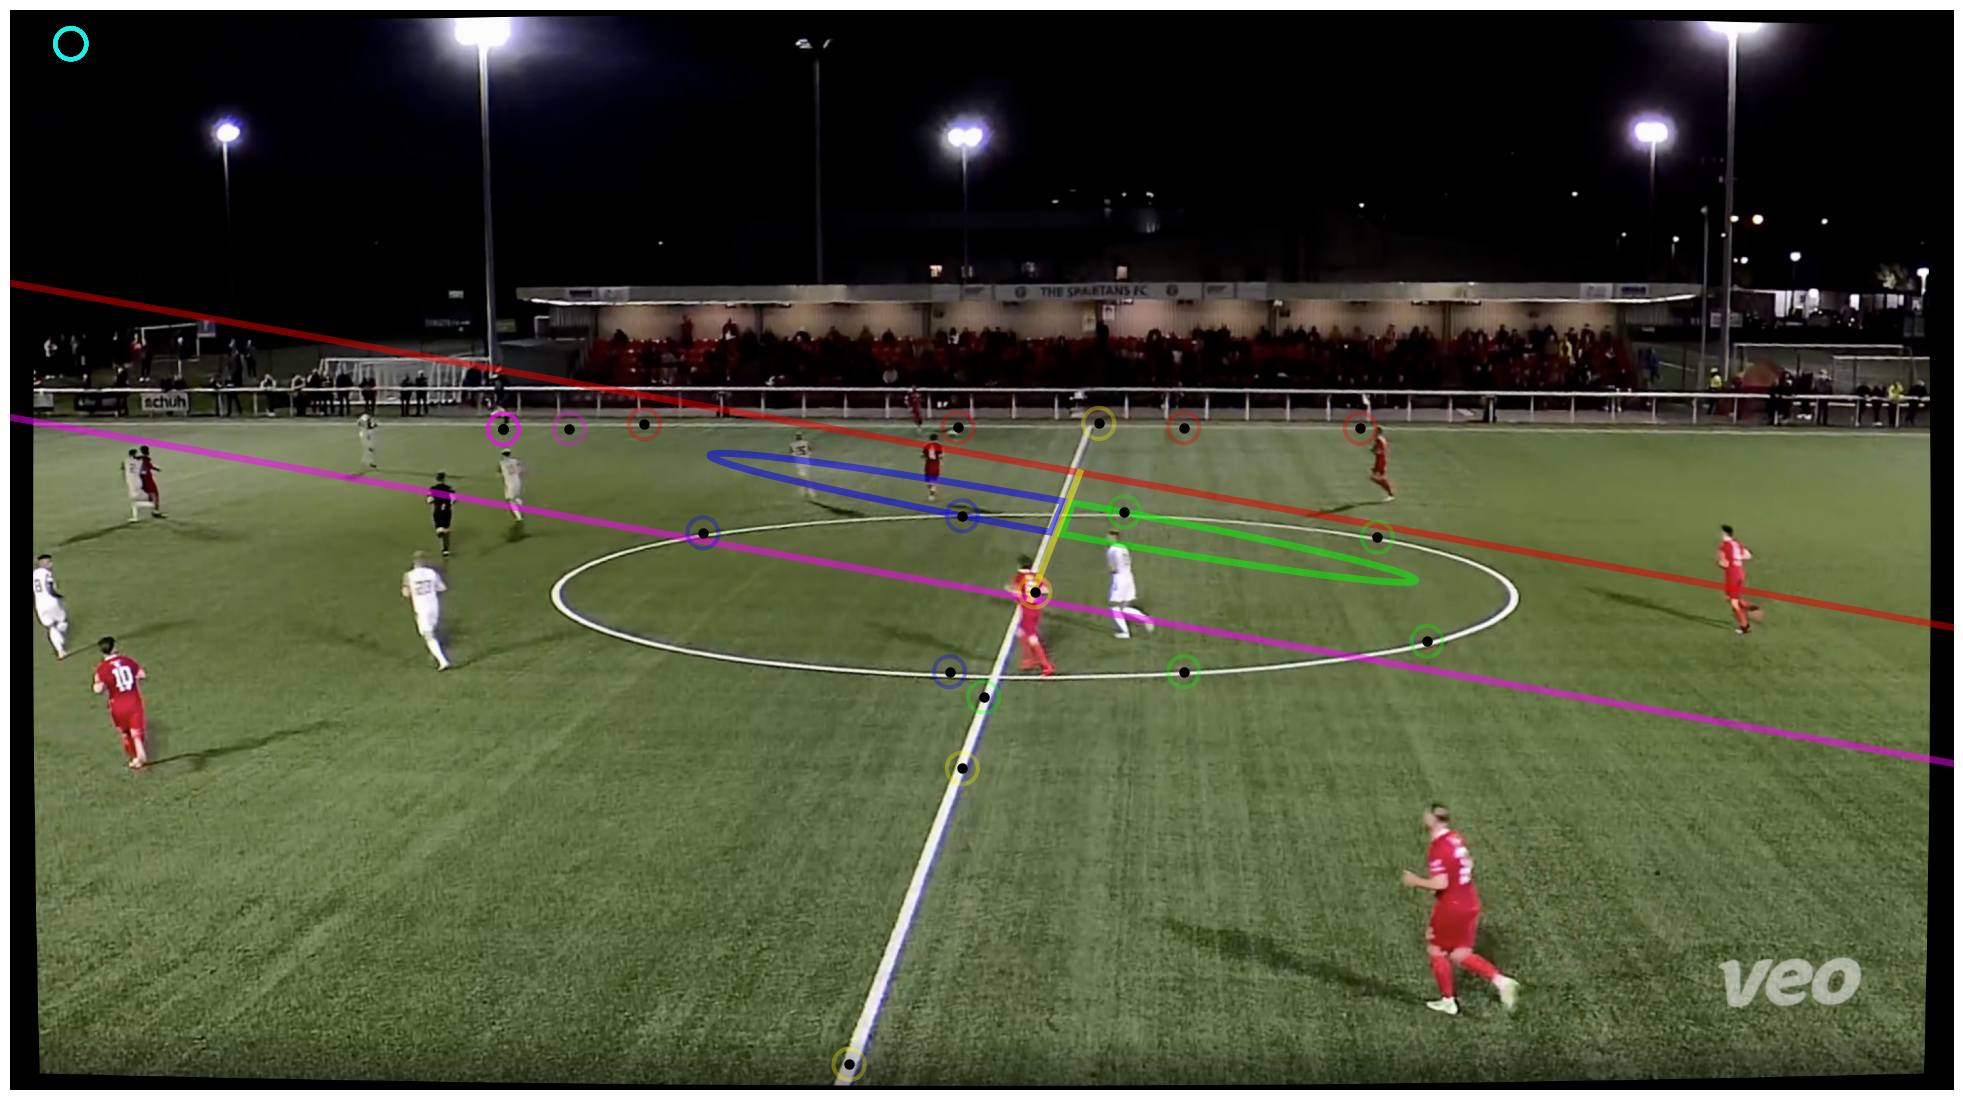

In [8]:
sample = df.iloc[0]

image_id = Path(sample.image_id).stem
print(f"{image_id=}")
image = Image.open(args.images_path / sample.image_id).convert("RGB")
image = T.functional.to_tensor(image)

cam = get_camera_from_per_sample_output(sample, args.lens_dist)

f"aov_deg={torch.rad2deg(cam.phi_dict['aov'])}, t={torch.stack([cam.phi_dict[k] for k in ['c_x', 'c_y', 'c_z']], dim=-1)}, pan_deg={torch.rad2deg(cam.phi_dict['pan'])} tilt_deg={torch.rad2deg(cam.phi_dict['tilt'])} roll_deg={torch.rad2deg(cam.phi_dict['roll'])}"

aov = torch.rad2deg(cam.phi_dict['aov']).numpy().squeeze() # angle of view
t = torch.stack([cam.phi_dict[k]
                for k in ['c_x', 'c_y', 'c_z']], dim=-1).numpy().squeeze()
pan = torch.rad2deg(cam.phi_dict['pan']).numpy().squeeze()
roll = torch.rad2deg(cam.phi_dict['roll']).numpy().squeeze()
tilt = torch.rad2deg(cam.phi_dict['tilt']).numpy().squeeze()

print(cam, cam.str_lens_distortion_coeff(b=0) if args.lens_dist else "")


points_line, points_circle = sample["points_line"], sample["points_circle"]

if args.lens_dist:
    # we visualize annotated points and image after undistortion
    image = cam.undistort_images(image.unsqueeze(0).unsqueeze(0)).squeeze()
    # print(points_line.shape) # expected: (1, 1, 3, S, N)
    points_line = SNProjectiveCamera.static_undistort_points(points_line.unsqueeze(0).unsqueeze(0), cam).squeeze()
    points_circle = SNProjectiveCamera.static_undistort_points(points_circle.unsqueeze(0).unsqueeze(0), cam).squeeze()
else:
    psi = None

fig, ax = viz.init_figure(args.image_width, args.image_height)
ax = viz.draw_image(ax, image)

ax = viz.draw_reprojection(ax, object3dcpu, cam)
ax = viz.draw_selected_points(
    ax,
    object3dcpu,
    points_line,
    points_circle,
    kwargs_outer={
        "zorder": 1000,
        "rasterized": False,
        "s": 500,
        "alpha": 0.3,
        "facecolor": "none",
        "linewidths": 3,
    },
    kwargs_inner={
        "zorder": 1000,
        "rasterized": False,
        "s": 50,
        "marker": ".",
        "color": "k",
        "linewidths": 4.0,
    },
)
dpi = 50

ax.set_xlim(0, args.image_width)
ax.set_ylim(args.image_height, 0)

plt.savefig(args.output_dir / f"{image_id}.pdf", dpi=dpi)
plt.savefig(args.output_dir / f"{image_id}.svg", dpi=dpi)
plt.savefig(args.output_dir / f"{image_id}.png", dpi=dpi)

In [9]:
x = np.array([50, -40, 0]).reshape(-1, 1)

x = np.concatenate([x, np.ones((1, x.shape[1]))], axis=0)

x = cam.get_transformation_to_camera() @ x

x = x / x[2]

x


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3) + inhomogeneous part.

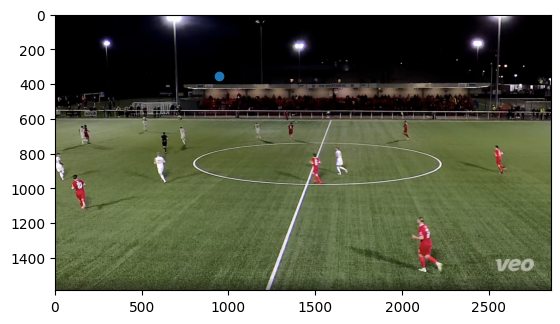

In [10]:
# Show jpeg image with matplotlib
import matplotlib.image as mpimg
img=mpimg.imread('data/datasets/wc14-test/pitch_lines_center.png')
imgplot = plt.imshow(img)
plt.scatter([946.40659697], [354.56231691])
